# Real-Time Multi-Object Tracking in Video Streams
## Ajmal Jalal, Aliaksei Matsarski - Team 2
## AAI-521-05 Applied Computer Vision for AI
## Instructor: Mohammad Yavarimanesh, Ph.D
## Shiley-Marcos School of Engineering, University of San Diego
## November 29, 2025

# 1. Overview

# 2. Data Pipeline & Preprocessing

#### **2.1 Setup basic environment and connect MOT20 data set**

In [ ]:
# --- basic environment setup ---
!pip install roboflow ultralytics opencv-python matplotlib seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
# Unzip MOT20 data set, it is uploaded to Google Drive and drive connected to Colab
!unzip -q "/content/drive/MyDrive/AAI-521-final/MOT20.zip" -d "/content/"

#### **2.2 Exploratory Data Analysis (EDA)**

```
# This is formatted as code
```



In [ ]:
import os
import zipfile
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob

base_dir = "/content/MOT20"
my_drive_progect_dir = "/content/drive/MyDrive/AAI-521-final"

# list sequences
train_sequences = sorted(glob.glob(f"{base_dir}/train/*"))
print("Sequences:", train_sequences)

Sequences: ['/content/MOT20/train/MOT20-01', '/content/MOT20/train/MOT20-02', '/content/MOT20/train/MOT20-03', '/content/MOT20/train/MOT20-05']


In [ ]:
# read one annotation file
seq = train_sequences[0]
gt_path = f"{seq}/gt/gt.txt"
cols = ["frame","id","x","y","w","h","conf","class","visibility"]
gt = pd.read_csv(gt_path, names=cols)

# basic info
print(gt.head())
print(gt['id'].nunique(), "unique objects across", gt['frame'].nunique(), "frames")

   frame  id    x    y    w    h  conf  class  visibility
0      1   1  199  813  140  268     1      1     0.83643
1      2   1  201  812  140  268     1      1     0.84015
2      3   1  203  812  140  268     1      1     0.84015
3      4   1  206  812  140  268     1      1     0.84015
4      5   1  208  812  140  268     1      1     0.84015
90 unique objects across 429 frames


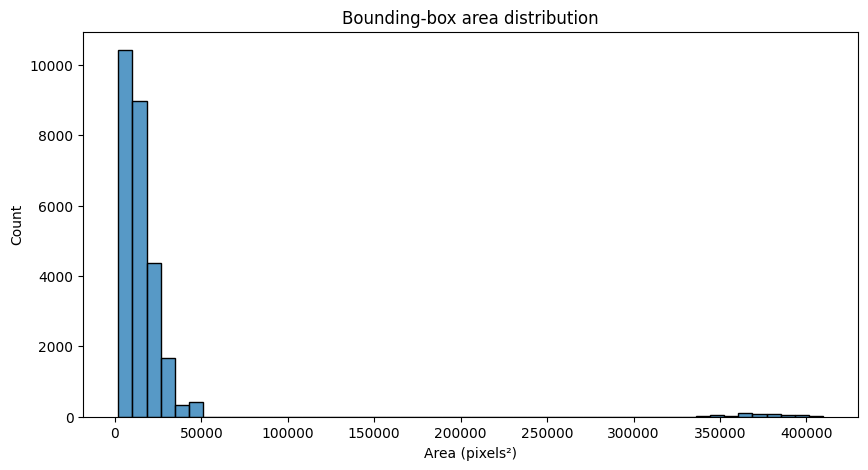

In [ ]:
# distribution plots
plt.figure(figsize=(10,5))
sns.histplot(gt['w']*gt['h'], bins=50)
plt.title("Bounding-box area distribution")
plt.xlabel("Area (pixels²)")
plt.show()

/tmp/ipython-input-1281106176.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  frame_id = int(gt['frame'].sample(1))


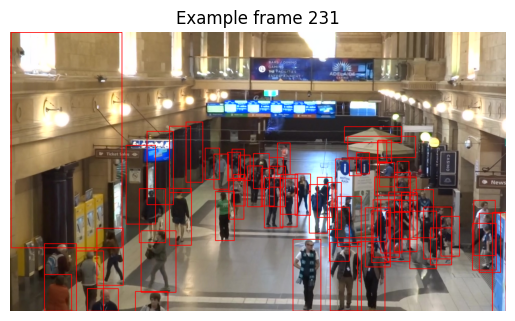

In [ ]:
# sample frame with annotations
frame_id = int(gt['frame'].sample(1))
img_path = f"{seq}/img1/{frame_id:06d}.jpg"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

for _, row in gt[gt.frame==frame_id].iterrows():
    x,y,w,h = map(int,[row.x,row.y,row.w,row.h])
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(img)
plt.axis("off")
plt.title(f"Example frame {frame_id}")
plt.show()

In [ ]:
# Missing or negative coordinates
gt.isna().sum()

,0
frame,0
id,0
x,0
y,0
w,0
h,0
conf,0
class,0
visibility,0


In [ ]:
# Object counts per frame
gt.groupby('frame')['id'].count().describe()

,id
count,429.000000
mean,62.114219
std,5.647223
min,52.000000
25%,57.000000
50%,64.000000
75%,67.000000
max,71.000000


In [ ]:
# Aspect-ratio stats
(gt['w']/gt['h']).describe()

,0
count,26647.000000
mean,0.561742
std,0.581628
min,0.043011
25%,0.371901
50%,0.417266
75%,0.490000
max,3.622951


#### **2.3 Pre-processing Pipeline**

##### MOT20 Preprocessing (Colab)

The preprocessing script located in /content/drive/MyDrive/AAI-521-final/mot20_preprocess.py. This script does:
 - reads MOT20 sequences (img1/ + gt/gt.txt)

 - filters valid ground truth (conf == 1)

 - letterbox-resizes frames to a square size (default 640)

 - converts MOT boxes (x, y, w, h) → YOLO normalized (x_center, y_center, w, h)

 - writes images/labels into train/val splits (per-sequence 80/20 by frame index)

 - emits lightweight EDA summaries per sequence and a dataset-level CSV

Run preprocessing:
```python
!python /content/drive/MyDrive/AAI-521-final/mot20_preprocess.py --src /content/MOT20 --dst /content/MOT20_yolo640 --size 640 --val_ratio 0.2
```

Outputs:
- `/content/MOT20_yolo640/train/{images,labels}`
- `/content/MOT20_yolo640/val/{images,labels}`
- `/content/MOT20_yolo640/summaries/*.csv` and `dataset_summary.csv`

Notes:
- We filter GT rows with `conf == 1` (per MOTChallenge convention).
- Bboxes are transformed to **YOLO normalized (x_center, y_center, w, h)** after **letterbox resize**.
- Classes default to a single class (0) for pedestrians; extend mapping if you add vehicles/animals.

In [ ]:
# Run preproccesing script
!python /content/drive/MyDrive/AAI-521-final/mot20_preprocess.py --src /content/MOT20 --dst /content/MOT20_yolo640 --size 640 --val_ratio 0.2

Processing MOT20-05: 100%|████████████████████████████| 3315/3315 [19:35<00:00,  2.82it/s]
[OK] Wrote 4 summaries and dataset to: /content/MOT20_yolo640


#### **2.4 Yolov8 data.yaml config file.**
The mot20_data.yaml locate in /content/drive/MyDrive/AAI-521-final/mot20_data.yaml. This config describe the resized data location.

The training can be run with the following command:
```python
!yolo task=detect mode=train model=yolov8n.pt data=mot20_data.yaml epochs=50 imgsz=640
```